In [2]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
#import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR

from transformers import AutoModelForImageClassification, ViTForImageClassification, \
                         ViTFeatureExtractor, Trainer, TrainingArguments, \
                         AutoFeatureExtractor, DeiTForImageClassificationWithTeacher, \
                         BeitForImageClassification, BeitFeatureExtractor
                         # PerceiverFeatureExtractor, PerceiverForImageClassificationConvProcessing

from AutoAugment.autoaugment import ImageNetPolicy

from PIL import Image

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [3]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cpu'

In [4]:
df = pd.read_csv("../data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1, random_state = 42).reset_index(drop=True)

df.shape

(31016, 2)

In [5]:
class food_set(Dataset):

    def __init__(self, df, labels_file, img_dir, extractor, transform = None, settype = "train"):
        self.df = df
        if settype == "train":
            self.img_labels = df[:29000]
        elif settype == "val":
            self.img_labels = df[29000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]      
        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [6]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)        
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [7]:
weights = [i[0] for i in (1 / (df.groupby("label").count() / len(df) * 100)).values]
weights.append(0)
weights = torch.Tensor(np.array(weights)).to(device)

In [8]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       ImageNetPolicy(),
                                       transforms.RandomHorizontalFlip()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224)])

feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [9]:
trainset = food_set(df, labels, img_dir, feature_extractor, transform = train_transforms, settype = "train")
valset = food_set(df, labels, img_dir, feature_extractor, transform = test_transforms, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(29000, 2016)

In [10]:
testset = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(testset, batch_size = 16)

len(testset)

FileNotFoundError: [Errno 2] No such file or directory: '../data/test_set/test_set'

In [11]:
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(768, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 81)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
model = model.to(device)

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/395M [00:00<?, ?B/s]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0002, betas=[0.9, 0.999])

scheduler = LinearLR(optimizer)

In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

search_space = {
    "lr": tune.uniform(0.001, 0.01),
    "wd": tune.uniform(0.0001,0.001)
}

In [7]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

In [8]:
def train_loop(config, scheduler = None):
    
    model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(768, 512)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(512, 81)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
    valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr = config["lr"], betas=[0.9, 0.999], weight_decay = config["wd"])
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(5)
        stats["accuracy"].append(1.25)

        for epoch in range(5):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)["logits"]
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'../../beit_2_fc_5_epochs.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()
            
            if scheduler:
                scheduler.step()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)["logits"]
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    tune.report(mean_accuracy=correct)
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [ ]:
from ray.tune import JupyterNotebookReporter
reporter = JupyterNotebookReporter(overwrite=True, max_report_frequency = 5)

In [ ]:
#Run the Raytune
analysis = tune.run(
    train_loop,
    num_samples=10,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space,
    progress_reporter=reporter)

loss: 4.314755  [    0/29000] epoch: 1
loss: 4.029017  [ 1600/29000] epoch: 1
loss: 3.888720  [ 3200/29000] epoch: 1
loss: 2.891151  [ 4800/29000] epoch: 1
loss: 2.906246  [ 6400/29000] epoch: 1
loss: 2.543405  [ 8000/29000] epoch: 1
loss: 3.301522  [ 9600/29000] epoch: 1
loss: 3.085182  [11200/29000] epoch: 1
loss: 1.646264  [12800/29000] epoch: 1
loss: 1.973597  [14400/29000] epoch: 1
loss: 0.992402  [16000/29000] epoch: 1
loss: 0.783397  [17600/29000] epoch: 1
loss: 1.244717  [19200/29000] epoch: 1
loss: 2.109953  [20800/29000] epoch: 1
loss: 0.992811  [22400/29000] epoch: 1
loss: 1.694929  [24000/29000] epoch: 1
loss: 2.773054  [25600/29000] epoch: 1
loss: 1.294542  [27200/29000] epoch: 1
loss: 0.773396  [28800/29000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 71.0%, Avg loss: 1.214206 



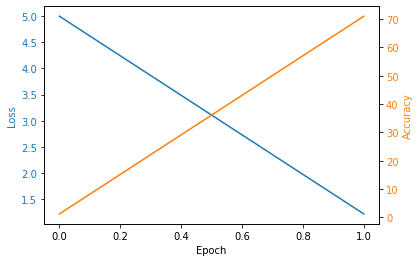

loss: 0.996334  [    0/29000] epoch: 2
loss: 0.429161  [ 1600/29000] epoch: 2
loss: 1.355429  [ 3200/29000] epoch: 2
loss: 1.517044  [ 4800/29000] epoch: 2
loss: 1.690464  [ 6400/29000] epoch: 2
loss: 0.714293  [ 8000/29000] epoch: 2
loss: 1.193516  [ 9600/29000] epoch: 2
loss: 1.178714  [11200/29000] epoch: 2
loss: 1.862382  [12800/29000] epoch: 2
loss: 1.511536  [14400/29000] epoch: 2
loss: 0.854852  [16000/29000] epoch: 2
loss: 0.611524  [17600/29000] epoch: 2
loss: 1.453357  [19200/29000] epoch: 2
loss: 1.939988  [20800/29000] epoch: 2
loss: 1.360332  [22400/29000] epoch: 2
loss: 0.685119  [24000/29000] epoch: 2
loss: 1.175933  [25600/29000] epoch: 2
loss: 0.269042  [27200/29000] epoch: 2
loss: 0.959424  [28800/29000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 73.5%, Avg loss: 1.064955 



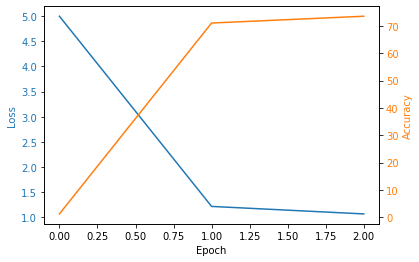

loss: 0.670938  [    0/29000] epoch: 3
loss: 1.261236  [ 1600/29000] epoch: 3
loss: 1.309055  [ 3200/29000] epoch: 3
loss: 0.295688  [ 4800/29000] epoch: 3
loss: 2.278414  [ 6400/29000] epoch: 3
loss: 0.251820  [ 8000/29000] epoch: 3
loss: 1.480039  [ 9600/29000] epoch: 3
loss: 2.078063  [11200/29000] epoch: 3
loss: 0.923717  [12800/29000] epoch: 3
loss: 0.301671  [14400/29000] epoch: 3
loss: 1.707372  [16000/29000] epoch: 3
loss: 2.210188  [17600/29000] epoch: 3
loss: 2.493220  [19200/29000] epoch: 3
loss: 0.476755  [20800/29000] epoch: 3
loss: 1.072693  [22400/29000] epoch: 3
loss: 1.495187  [24000/29000] epoch: 3
loss: 1.059433  [25600/29000] epoch: 3
loss: 0.600278  [27200/29000] epoch: 3
loss: 1.714086  [28800/29000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 75.1%, Avg loss: 1.001283 



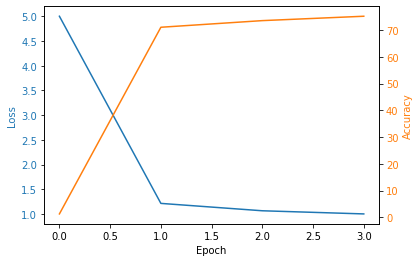

loss: 0.260397  [    0/29000] epoch: 4
loss: 0.467472  [ 1600/29000] epoch: 4
loss: 1.400018  [ 3200/29000] epoch: 4
loss: 0.554619  [ 4800/29000] epoch: 4
loss: 0.451944  [ 6400/29000] epoch: 4
loss: 0.981406  [ 8000/29000] epoch: 4
loss: 1.566610  [ 9600/29000] epoch: 4
loss: 2.069041  [11200/29000] epoch: 4
loss: 1.759398  [12800/29000] epoch: 4
loss: 0.741818  [14400/29000] epoch: 4
loss: 1.474681  [16000/29000] epoch: 4
loss: 1.597664  [17600/29000] epoch: 4
loss: 1.385096  [19200/29000] epoch: 4
loss: 1.252769  [20800/29000] epoch: 4
loss: 1.168023  [22400/29000] epoch: 4
loss: 1.796345  [24000/29000] epoch: 4
loss: 2.295390  [25600/29000] epoch: 4
loss: 1.471257  [27200/29000] epoch: 4
loss: 0.845698  [28800/29000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.981960 



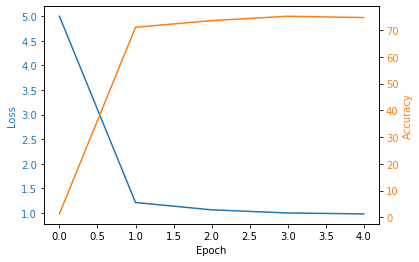

loss: 2.207216  [    0/29000] epoch: 5
loss: 1.983005  [ 1600/29000] epoch: 5
loss: 1.014561  [ 3200/29000] epoch: 5
loss: 1.219368  [ 4800/29000] epoch: 5
loss: 0.767215  [ 6400/29000] epoch: 5
loss: 1.137175  [ 8000/29000] epoch: 5
loss: 1.032646  [ 9600/29000] epoch: 5
loss: 0.897925  [11200/29000] epoch: 5
loss: 1.414832  [12800/29000] epoch: 5
loss: 0.787019  [14400/29000] epoch: 5
loss: 0.204325  [16000/29000] epoch: 5
loss: 1.443088  [17600/29000] epoch: 5
loss: 0.509816  [19200/29000] epoch: 5
loss: 0.866165  [20800/29000] epoch: 5
loss: 0.843159  [22400/29000] epoch: 5
loss: 0.751359  [24000/29000] epoch: 5
loss: 1.566610  [25600/29000] epoch: 5
loss: 1.144917  [27200/29000] epoch: 5
loss: 0.707998  [28800/29000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.955678 



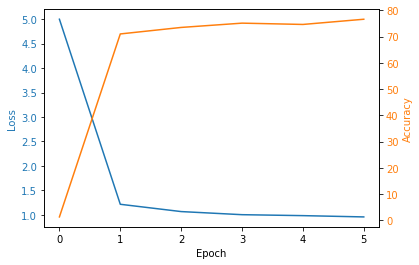

In [15]:
stats = train_loop(trainloader, valloader, model, criterion, optimizer)

In [15]:
pd.DataFrame(stats).to_csv("training_beit_data_aug_big_29k_30_epochs_imgnetpol.csv")

In [16]:
PATH = f'./beit_2_fc_5_epochs.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = model(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 479/479 [02:43<00:00,  2.94it/s]


In [18]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,80
1,test_10.jpg,45
2,test_100.jpg,25
3,test_1000.jpg,29
4,test_1001.jpg,37


In [19]:
test_df.to_csv("./submissions/submission_beit_fc2_30_epochs_imgnetpol.csv", index=False)